## PySpark ML-Classification example

- Predict if the client will subscribe a term deposit. Data available on [Kaggle](https://www.kaggle.com/rouseguy/bankbalanced/home) - direct marketing campaigns of a banking institution

- Original tutorial available on: [TDS](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

In [1]:
import pyspark
from pyspark.sql import SparkSession

## Create a spark-session
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

In [2]:
df = spark.read.csv('/home/patel.mehu/bank.csv', header = True, inferSchema = True)
df.printSchema()                   

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [3]:
df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

In [4]:
import pandas as pd
pd.DataFrame(df.take(5), columns = df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [5]:
## Show distribution of target (both of the following works)
df.groupBy('deposit').count().show()
# df.groupBy('deposit').count().toPandas()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



### EDA

In [9]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [6]:
## Summary of numerical features
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas()

,summary,age,balance,day,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,15.658036194230425,371.99381831213043,2.508421429851281,51.33040673714388,0.8325568894463358
2,stddev,11.913369192215518,3225.413325946149,8.420739541006462,347.12838571630687,2.7220771816614824,108.75828197197717,2.292007218670508
3,min,18,-6847,1,2,1,-1,0
4,max,95,81204,31,3881,63,854,58


In [7]:
## Correlations among numerical features
numeric_data = df.select(numeric_features).toPandas()
axs = pd.scatter_matrix(numeric_data, figsize = (10,10))

n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

/shared/centos7/python/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


In [8]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



#### Build a classifier

In [28]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

## Convert categorical columns into OHE-features
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for col in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = col, outputCol = col+'Index')
    encoder = OneHotEncoderEstimator(inputCols = [stringIndexer.getOutputCol()], outputCols = [col+'classVec'])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assembleInputs = [c+'classVec' for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols = assembleInputs, outputCol = 'features')
stages += [assembler]

In [32]:
from pyspark.ml import Pipeline

## Build a model pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [48]:
## Train/test split
train, test = df.randomSplit([0.7, 0.3], seed = 11)
print ('Training counts: ' + str(train.count()))
print ('Test counts: ' + str(test.count()))

Training counts: 7895
Test counts: 3267


### Logistic-Regression Model

In [50]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter = 100)
lrModel = lr.fit(train)

In [51]:
import matplotlib.pyplot as plt
import numpy as np

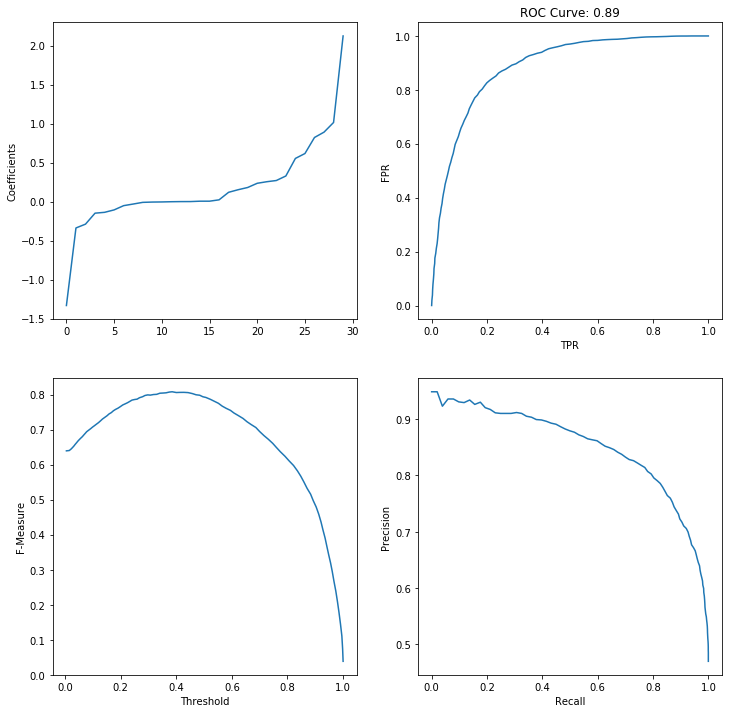

In [73]:
beta = np.sort(lrModel.coefficients)
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
f = trainingSummary.fMeasureByThreshold.toPandas()
pr = trainingSummary.pr.toPandas()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize = (12,12), nrows = 2, ncols = 2)
ax1.plot(beta)
ax1.set_ylabel('Coefficients')

ax2.plot(roc['FPR'], roc['TPR'])
ax2.set_xlabel('TPR')
ax2.set_ylabel('FPR')
ax2.set_title('ROC Curve: ' + str(round(trainingSummary.areaUnderROC, 2)))

ax3.plot(f['threshold'],f['F-Measure'])
ax3.set_ylabel('F-Measure')
ax3.set_xlabel('Threshold')


ax4.plot(pr['recall'],pr['precision'])
ax4.set_ylabel('Precision')
ax4.set_xlabel('Recall')

plt.show()

In [76]:
predictions = lrModel.transform(test)

In [79]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print ('AUC: ', evaluator.evaluate(predictions))

AUC:  0.8869372600692063


In [83]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.01, 0.5, 2.0])
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
            .addGrid(lr.maxIter, [10, 50, 100])
            .build())
cv = CrossValidator(estimator = lr, estimatorParamMaps = paramGrid,  evaluator = evaluator, numFolds = 5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print ('Test-AUC: ', evaluator.evaluate(predictions))

Test-AUC:  0.8892724112987671


### Random-Forest Classifier

In [85]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

evaluator = BinaryClassificationEvaluator()
print ('Test-AUC: ', evaluator.evaluate(predictions))

Test-AUC:  0.889359829395887


In [93]:
featureImportances = list(rfModel.featureImportances.toArray())

30

In [86]:
print (rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: auto)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: 